# Investigating Hybrid Strategies for Systematic Literature Review
**Experiment 3**

Esse notebook exibe:
1. Matriz de Citação;
2. Matriz de Indicação de Passos para encontrar os artigos selecionados;
3. Grafo de Indicação de passos para encontrar os artigos selecionados;
4. Matriz de Backard e Forward de cada artigo;

Atenção - O Grafo de Citação está no notebook CitationGraph.ipynb

In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years, find_citation
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
from collections import OrderedDict
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

custom_strategies.LIMIT_YEAR = 2016
reload()
# !pip install matplotlib-venn

In [2]:
selected = [(varname, w) for varname, w in load_work_map_all_years() if w.category == "snowball"]
names = [varname for varname, w in selected]
#names

In [3]:

order = OrderedDict([
 ('liao2005a', 0),
('liao2005b', 1),
('soydan2006a', 2),
('lee2008a', 3),
('rungratri2008a', 4),
('ryu2008a', 5),
('gazel2009a', 6),
('lee2009a', 7),
('stolfa2010a', 8),
('gazel2012a', 9),
('grambow2012a', 10),
('soydan2012a', 11),
('grambow2013a', 12),
('kabaale2016a', 13),
])
id_to_varname = OrderedDict(sorted([
  (index, varname) for varname, index in order.items()
]))
selected = [(varname, work_by_varname(varname)) for index, varname in id_to_varname.items()]
names = ['{} S{}'.format(w.year, order[varname] + 1) for varname, w in selected]


lista = [(w.name, w.authors, w.year, varname, 'S{}'.format(order[varname] + 1), names) for varname, w in selected]
df = pd.DataFrame (lista)
df

df = df[[ 0, 1, 2, 3, 4]]
df.columns = ['Title', 'Authors', 'Year', 'Metakey', 'Study']
df1 = df.sort_values(by = ['Year', 'Study'], ascending=True)

#df1 = df.groupby('Year').apply(lambda x: x.sort_values(by = ['Year', 'Study'], ascending = True))

df1

df1_style = df1.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector="th", props=[("text-align", "left")]),
])
print ('\n \033[1m Selected Studies \033[0m')
df1_style

#from snowballing.dbmanager import insert, set_attribute
#for key, value in order.items():
#    set_attribute(key, "selected_order", "{}".format(value + 1))


  Selected Studies 


,Title,Authors,Year,Metakey,Study
0,A software process ontology and its application,"Liao, Li and Qu, Yuzhong and Leung, H",2005,liao2005a,S1
1,An ontology-based approach to express software processes,"Liao, Li and Qu, Yuzhong and Leung, H",2005,liao2005b,S2
2,An OWL ontology for representing the CMMI-SW model,"Soydan, Gokhan Halit and Kokar, M",2006,soydan2006a,S3
3,Ontology-based intelligent decision support agent for CMMI project monitoring and control,"Lee, Chang-Shing and Wang, Mei-Hui and Chen, Jui-Jen",2008,lee2008a,S4
4,Project assets ontology (PAO) to support gap analysis for organization process improvement based on CMMI v. 1.2,"Rungratri, Suwanit and Usanavasin, Sasiporn",2008,rungratri2008a,S5
5,A strategic test process improvement approach using an ontological description for MND-TMM,"Ryu, Hoyeon and Ryu, Dong-Kuk and Baik, Jongmoon",2008,ryu2008a,S6
6,A CMMI Ontology for An Ontology-Based Software Process Assessment Tool,"Gazel, Sema and Tarhan, Ayca and Sezer, Ebru",2009,gazel2009a,S7
7,Ontology-based computational intelligent multi-agent and its application to CMMI assessment,"Lee, Chang-Shing and Wang, Mei-Hui",2009,lee2009a,S8
8,Building process definition with ontology background,"Stolfa, Svatopluk and KoZusznik, Jan and Kosinár, Michal and Duzí, Marie and Cíhalová, Martina and Vondrák, Ivo",2010,stolfa2010a,S9
9,An ontology based infrastructure to support CMMI-based software process assessment,"Gazel, Sema and Sezer, Ebru Akcpinar and Tarhan, Ayca",2012,gazel2012a,S10


# Citation Matrix

Leitura da matriz de citação: 
1. A linha identifica as referencias do artigo. Exemplo: Artigo da Linha (2010 S8 - guzmán2010a) referencia os artigos das colunas (2009 S7) e (2010 S9). Verifiquei que no Backward de (2010 S8 - guzmán2010a) os artigos (2009 S7) e (2010 S9) existem.
2. A coluna identifica quem citou ela. Exemplo: Artigo da coluna (2011 S5) foi citado por linha (2015 S4 - petersen2015a). Verifiquei que no Forward de (2011 S5) o artigo (2015 S4) existe. 
3. O " - " indica a impossibilidade do artigo da linha ter nas referências (citar) o artigo da coluna, devido ao ano de publicação. Exemplo: Linha 5 - (ref 2011 S5  - id kaneko 2011a) não poderia ter nas referências o artigo da coluna (cited 2015 S4).


In [4]:
matrix1 = [
    [varname] + ['-' if cited.year > citer.year else 
     'x' if find_citation(citer, cited) else ''
     for _, cited in selected]
     for varname, citer in selected
]
df = pd.DataFrame(matrix1)
#df.set_index(names)
df.set_axis(0, names)
df.set_axis(1, ["id"] + names)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v == 'x' else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: set_axis now takes "labels" as first argument, and "axis" as named parameter. The old form, with "axis" as first parameter and "labels" as second, is still supported but will be deprecated in a future version of pandas.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: set_axis now takes "labels" as first argument, and "axis" as named parameter. The old form, with "axis" as first parameter and "labels" as second, is still supported but will be deprecated in a future version of pandas.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version o

cited,id,2005 S1,2005 S2,2006 S3,2008 S4,2008 S5,2008 S6,2009 S7,2009 S8,2010 S9,2012 S10,2012 S11,2012 S12,2013 S13,2016 S14
ref,,,,,,,,,,,,,,,
2005 S1,liao2005a,,,-,-,-,-,-,-,-,-,-,-,-,-
2005 S2,liao2005b,,,-,-,-,-,-,-,-,-,-,-,-,-
2006 S3,soydan2006a,x,,,-,-,-,-,-,-,-,-,-,-,-
2008 S4,lee2008a,,,,,,,-,-,-,-,-,-,-,-
2008 S5,rungratri2008a,,,x,x,,,-,-,-,-,-,-,-,-
2008 S6,ryu2008a,x,,x,,,,-,-,-,-,-,-,-,-
2009 S7,gazel2009a,x,,x,x,,,,x,-,-,-,-,-,-
2009 S8,lee2009a,,,,,,,,,-,-,-,-,-,-
2010 S9,stolfa2010a,,,,,,,,,,-,-,-,-,-


In [5]:
with open("output/table.html", "wb") as html:
    html.write(df_style.render().encode("utf-8"))

In [6]:
# [row[0]]
nmatrix = [[(1 if x == 'x' else float('inf')) for x in row[1:]]
 for row in matrix1]
for i, row in enumerate(nmatrix):
    for j, v in enumerate(row):
        if v == 1:
            nmatrix[j][i] = 1
        if i == j:
            nmatrix[i][j] = 0
pmax = 1
size = len(matrix1)
for k in range(size):
    for i in range(size):
        for j in range(size):
            if nmatrix[i][j] > nmatrix[i][k] + nmatrix[k][j]:
                nmatrix[i][j] = nmatrix[j][i] = nmatrix[i][k] + nmatrix[k][j]
                pmax = max(pmax, nmatrix[i][j])

pmax

3

# Matrix - Steps to find the article

1. Quantidade de passos para encontrar um artigo da lista dos selecionados, através dos artigos encontrados nas referências e por quem cita ele. Exemplo: Artigo da linha (2015 S4 petersen2015a) encontra através de um passo, nas referências dele, o artigo da coluna 2011 S5. E encontra o artigo da coluna 2010 S6 através de 3 passos, através dos artigos referenciados que referenciam outros.


In [7]:
matrix3 = [
    [s[0]] + row
     for s, row in zip(selected, nmatrix)
]
df = pd.DataFrame(matrix3)
#df.set_index(names)
df.set_axis(0, names)
df.set_axis(1, ["id"] + names)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v != float('inf') and isinstance(v, float) else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: set_axis now takes "labels" as first argument, and "axis" as named parameter. The old form, with "axis" as first parameter and "labels" as second, is still supported but will be deprecated in a future version of pandas.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: set_axis now takes "labels" as first argument, and "axis" as named parameter. The old form, with "axis" as first parameter and "labels" as second, is still supported but will be deprecated in a future version of pandas.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of 

cited,id,2005 S1,2005 S2,2006 S3,2008 S4,2008 S5,2008 S6,2009 S7,2009 S8,2010 S9,2012 S10,2012 S11,2012 S12,2013 S13,2016 S14
ref,,,,,,,,,,,,,,,
2005 S1,liao2005a,0,inf,1,2,2,1,1,2,inf,1,1,1,1,inf
2005 S2,liao2005b,inf,0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2006 S3,soydan2006a,1,inf,0,2,1,1,1,2,inf,1,1,1,1,inf
2008 S4,lee2008a,2,inf,2,0,1,3,1,2,inf,1,3,1,3,inf
2008 S5,rungratri2008a,2,inf,1,1,0,2,2,2,inf,1,2,1,2,inf
2008 S6,ryu2008a,1,inf,1,3,2,0,2,3,inf,2,2,2,2,inf
2009 S7,gazel2009a,1,inf,1,1,2,2,0,1,inf,1,2,2,2,inf
2009 S8,lee2009a,2,inf,2,2,2,3,1,0,inf,1,3,1,3,inf
2010 S9,stolfa2010a,inf,inf,inf,inf,inf,inf,inf,inf,0,inf,inf,inf,inf,inf


# Graph Citation - Steps to Find Article

1. Algoritmo utilizado para gerar o grafo: Algoritmo de Floyd-Warshall — Determina a distância entre todos os pares de vértices de um grafo.
2. Exemplo: Círculo do Grafo (2010 S6 35 5) significa que o artigo (2010 S6) encontra 35 artigos da lista dos 51 artigos, através de 5 passos.

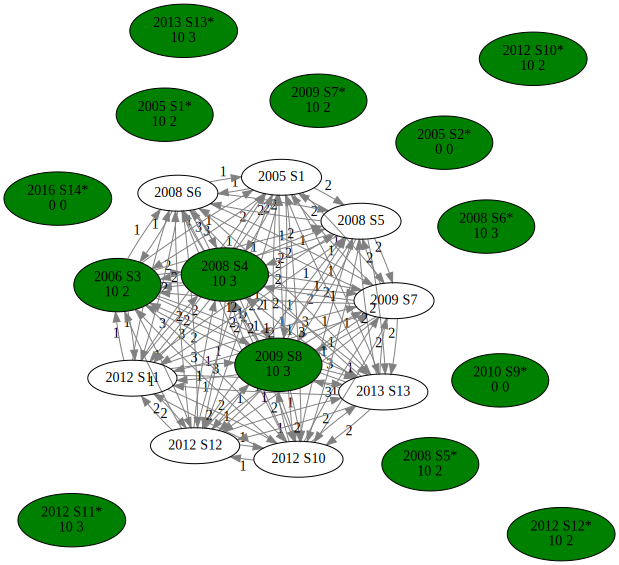

In [8]:
from subprocess import Popen, PIPE as P
class ViewMatrix:
    def __init__(self, nmatrix, names):
        self.nmatrix = nmatrix
        self.names = names
        
    @property
    def dot(self):
        text = ["digraph G {", "graph [ overlap=false ]"]
        for i, name in enumerate(self.names):
            filtered = [x for j, x in enumerate(self.nmatrix[i]) if x != float('inf') if j != i]
            total = sum(1 for x in filtered)
            maxsteps = max(filtered) if filtered else 0
            work = work_by_varname(id_to_varname[int(self.names[i].split()[-1][1:]) - 1])
            color = "green" if getattr(work, 'final_selected', 0) else "LightGreen"
            nameseed = name + "*"
            name = nameseed if getattr(work, 'seed_set', 0) else name
            #color = "green" if {x for _, x in load_work_map_all_years() if x.category == "snowball"} else "white"
            text.append(f'"{name}" [fillcolor="{color}", style=filled, label="{name}\n{total} {maxsteps}"];')
        for i, lis in enumerate(self.nmatrix):
            for j, v in enumerate(lis):
                if v != float('inf') and j != i:
                    text.append('"{}" -> "{}" [label="{}" color="gray"]'.format(self.names[i], self.names[j], v))
        text.append("}")
        return '\n'.join(text)

    def _ipython_display_(self):
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['neato', '-T', "svg", "-Goutputorder=edgesfirst"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/svg+xml'] = image.decode("utf-8")
        except OSError as e:
            print(e)
            if e.errno != os.errno.ENOENT:
                raise

        display(bundle, raw=True)
m = ViewMatrix(nmatrix, names)
m

# Backward and Forward - Details

1. Quantidade de artigos que visitou e em quantos passos para encontrar o artigo da lista dos selecionados;
2. Quantidade de artigos encontrados via backward e quantos foram selecionados;
3. Quantidade de artigos encontrados via forward e quantos foram selecionados.

In [9]:
strategy = Strategy({})
matrix2 = [[
    "S", "varname", "visits", "steps",
    "total backward", "selected backward",
    "total forward", "selected forward",
    "backward list", "selected backward list",
    "forward list", "selected forward list"
] + ["Step {}".format(i + 1) for i in range(pmax)]]
for varname, index in order.items():
    work = work_by_varname(varname)
    backward = strategy.ref[work]
    selected_backward = [x for x in backward if x.category == "snowball"]
    forward = strategy.rev_ref[work]
    selected_forward = [x for x in forward if x.category == "snowball"]
    steps = [[] for x in range(pmax)]
    for i, v in enumerate(nmatrix[index]):
        if v != float('inf') and v != 0:
            steps[v - 1].append(id_to_varname[i])
    steps = [", ".join(s) for s in steps]
    filtered = [x for j, x in enumerate(nmatrix[index]) if x != float('inf') if j != i]
    total = sum(1 for x in filtered)
    maxsteps = max(filtered) if filtered else 0
    row = [
        "S{}".format(index + 1), varname,
        total, maxsteps,
        len(backward), len(selected_backward),
        len(forward), len(selected_forward),
        ", ".join(x.metakey for x in backward),
        ", ".join(x.metakey for x in selected_backward),
        ", ".join(x.metakey for x in forward),
        ", ".join(x.metakey for x in selected_forward),
    ] + steps
    
    matrix2.append(row)
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_colwidth',1000)
df = pd.DataFrame(matrix2)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,S,varname,visits,steps,total backward,selected backward,total forward,selected forward,backward list,selected backward list,forward list,selected forward list,Step 1,Step 2,Step 3
1,S1,liao2005a,11,2,15,0,64,7,"paulk1993a, isoiec1998a, haase1994a, wang2000a, cmusei2002a, conradi2002a, lopez2001a, conradi1994a, ben1993a, bandinelli1993a, deng2003a, alonso1995a, liao2004a, chandrasekaran1999a, patel2004a",,"gazel2009a, grambow2012a, grambow2013a, zhao2009a, pardo2012a, bringuente2011a, colomo2008a, grambow2011d, al2011a, caffery2012a, jeners2013a, ryu2008a, grambow2011e, gazel2012a, fitsilis2014a, kayed2010a, soydan2012a, sarantis2010a, teuteberg2009a, pricope2011a, jeners2012a, teuteberg2013a, pardo2014a, fadila2009a, bibi2014a, martoglia2011a, jeners2012b, jeners2013b, mora2010a, hamri2015a, aoussat2012b, jeners2012c, demirsoy2013a, mora2013a, tarhan2017a, colomo2008b, pardo2014ab, souza2012a, pyshkin2015a, kluth2013a, ahmad2009a, colomo2008ab, roongsangjan2017a, lourinho2017a, balaji2012a, nielsen2008a, zemaitytė2016a, liu2007ab, chansylilath2014a, ngwenya2016a, nizar2010a, ciancarini2018a, aoussat2014a, noroozi2012a, butka2015a, shanthini2013a, moraa2010a, fitsilis2015a, cadavid2018a, lang2014a, ontolojilerin2011a, aoussat2012a, aau2009a, soydan2006a","gazel2009a, grambow2012a, grambow2013a, ryu2008a, gazel2012a, soydan2012a, soydan2006a","soydan2006a, ryu2008a, gazel2009a, gazel2012a, grambow2012a, soydan2012a, grambow2013a","lee2008a, rungratri2008a, lee2009a",
2,S2,liao2005b,1,0,11,0,1,0,"conradi2002a, lopez2001a, wang2000b, berners2001a, w3c2004a, (0, ), (0, ), w32001a, w32001b, miller2003a, liao2004b",,tarhan2017a,,,,
3,S3,soydan2006a,11,2,6,1,52,14,"cmmi2002ab, w3c2004c, carnegie2005a, carnegie2006a, mendes2004a, liao2005a",liao2005a,"gazel2009a, gazel2012a, grambow2012a, grambow2013a, rungratri2008a, ryu2008a, pardo2012a, colomo2008a, grambow2011d, ryu2008a, grambow2011e, sharifloo2008b, gazel2012a, fitsilis2014a, rilling2008a, rilling2008b, schugerl2009a, hyland2008a, soydan2012a, rungratri2008a, mejia2016a, grambow2013a, grambow2012a, martoglia2011a, bergamaschi2015a, hmood2010a, mora2010a, pardo2015a, hamri2015a, ying2009a, gazel2009a, mora2013a, yoshidome2014a, proen2016a, baldassarre2016a, tarhan2017a, hyland2008b, colomo2008b, yoshidome2014b, shia2015a, albuquerque2017a, colomo2014a, ciancarini2018a, nielsen2008a, proen2018a, moraa2010a, fitsilis2015a, cadavid2018a, rilling2008c, peld2015a, aoussat2012a, soydan2012a","gazel2009a, gazel2012a, grambow2012a, grambow2013a, rungratri2008a, ryu2008a, ryu2008a, gazel2012a, soydan2012a, rungratri2008a, grambow2013a, grambow2012a, gazel2009a, soydan2012a","liao2005a, rungratri2008a, ryu2008a, gazel2009a, gazel2012a, grambow2012a, soydan2012a, grambow2013a","lee2008a, lee2009a",
4,S4,lee2008a,11,3,15,0,107,4,"gandon2006a, vetere1999a, musen1995a, huang2005a, pan2004a, hsieh2006a, hamdi2006a, pratt2006a, li2006a, cmmi2005a, wu2006a, han2006a, russo2006a, yager1988a, yager1993a",,"gazel2009a, gazel2012a, bobillo2011a, lee2011a, lee2009d, isern2011a, balaji2010a, lee2010a, chen2011b, milea2012a, bajo2009a, abanda2013a, kazemifard2011a, acampora2011a, acampora2010a, kang2012a, plaza2009a, zhou2015a, lee2008d, acampora2011b, kalpana2011a, gonzalez2011a, cheng2011a, nasir2008a, wang2008b, lee2012a, alfaraj2011a, lee2009e, fitsilis2014a, garrido2010a, crespo2012a, shoaib2010a, yang2010a, grzybek2014a, lee2010b, lee2010c, rungratri2008a, lee2008c, hoock2010a, lee2007ab, wang2012b, wang2010a, lee2008e, milea2013a, nojima2011a, chen2011c, plaza2016a, wang2011a, chang2009a, andrade2008b, lee2011b, wang2008c, xu2013a, xu2015a, haghighi2012a, guo2010a, lagos2017a, cheng2009b, kuo2011a, heinzle2017a, wang2013a, mora2013a, liu2007a, lee2007d, tarhan2017a, xua2014a, cristani2010a, cristani2008a, wang2013b, freitas2017a, amid2013a, japan2009a, japan2010a, quevedo2015a, japan2016a, hou2015a, laroque2012a, erdem2010a, dias2013a, poulos2017a, ramadhan201

In [10]:
df.to_excel("tabela_grafo.xlsx")

In [11]:
#nmatrix[13]